## Passo 0: SETUP - Importações e Montegem do Drive.

In [12]:
# ======================================= #
#        Instalando as dependências       #
# ======================================= #

!pip install pandas numpy matplotlib seaborn scipy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, norm, binom, poisson, shapiro, t
from scipy import stats

# Ajustes visuais
sns.set_theme(style="whitegrid")
plt.style.use("default")

print("Configuração concluída! Bibliotecas carregadas com sucesso!")


Configuração concluída! Bibliotecas carregadas com sucesso!


In [32]:
# =============================== #
#   Carregando os arquivos CSV    #
# =============================== #

collisions = pd.read_csv(
    "../archives/Motor_Vehicle_Collisions_-_Crashes.csv"
)

ev = pd.read_csv(
    "../archives/Electric_Vehicle_Population_Data.csv"
)

print("Dados carregados com sucesso!")
collisions.head()

C:\Users\gubez\AppData\Local\Temp\ipykernel_14288\3002376908.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(


Dados carregados com sucesso!


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


## Passo 1: Limpeza dos dados.
Etapa de limpeza dos dados a fim garantir que os dados sejam corretos, consistentes e utilizáveis, evitando erros e resultados imprecisos na análise ou no modelo.

In [33]:
# ========================================================================= #
#    Padronização das colunas, datas, tipos, duplicatas e missing values    #
# ========================================================================= #

# 1) Função para padronizar nomes das colunas
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("[^0-9a-zA-Z_]", "", regex=True)
    )
    return df

# Aplicando ao dataset
collisions = clean_columns(collisions)
ev = clean_columns(ev)

print("Colunas padronizadas!")

# 2) Tratar datas (colunas variam dependendo da versão do dataset)
date_cols = ["crash_date", "crash_time"]

for col in date_cols:
    if col in collisions.columns:
        collisions[col] = pd.to_datetime(collisions[col], errors="coerce")

# Criar coluna 'hour' a partir de crash_time
if "crash_time" in collisions.columns:
    collisions["hour"] = pd.to_datetime(
        collisions["crash_time"].astype(str),
        errors="coerce"
    ).dt.hour

print("Datas e horários tratados!")

# 3) Remover duplicatas
before = collisions.shape[0]
collisions = collisions.drop_duplicates()
after = collisions.shape[0]

print(f"Removidas {before - after} linhas duplicadas.")

# 4) Relatório de valores ausentes
missing = collisions.isna().mean().sort_values(ascending=False)
print("\n==== MISSING VALUES (%) ====")
print((missing * 100).round(2))

# 5) Convertendo colunas numéricas (exemplo comum)
num_cols = [
    "number_of_persons_injured",
    "number_of_persons_killed",
    "number_of_pedestrians_injured",
    "number_of_cyclists_injured",
    "number_of_motorists_injured"
]

for col in num_cols:
    if col in collisions.columns:
        collisions[col] = pd.to_numeric(collisions[col], errors="coerce").fillna(0)

print("\nConversão de tipos numéricos concluída!")

collisions.head()


Colunas padronizadas!


C:\Users\gubez\AppData\Local\Temp\ipykernel_14288\2350882846.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  collisions[col] = pd.to_datetime(collisions[col], errors="coerce")


Datas e horários tratados!
Removidas 0 linhas duplicadas.

==== MISSING VALUES (%) ====
vehicle_type_code_5              99.56
contributing_factor_vehicle_5    99.55
vehicle_type_code_4              98.41
contributing_factor_vehicle_4    98.35
vehicle_type_code_3              93.05
contributing_factor_vehicle_3    92.76
off_street_name                  82.36
cross_street_name                38.22
zip_code                         30.64
borough                          30.63
on_street_name                   21.79
vehicle_type_code_2              20.08
contributing_factor_vehicle_2    16.06
latitude                         10.81
location                         10.81
longitude                        10.81
vehicle_type_code_1               0.73
contributing_factor_vehicle_1     0.35
number_of_persons_killed          0.00
number_of_persons_injured         0.00
crash_time                        0.00
crash_date                        0.00
number_of_pedestrians_killed      0.00
number_of_pedes

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,off_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,hour
0,2021-09-11,2025-11-27 02:39:00,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN,2
1,2022-03-26,2025-11-27 11:45:00,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN,11
2,2023-11-01,2025-11-27 01:29:00,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN,1
3,2022-06-29,2025-11-27 06:55:00,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN,6
4,2022-09-21,2025-11-27 13:21:00,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,13


In [34]:
# ========================================================= #
#  Cria um novo diretório para guardar os dados já limpos   #
# ========================================================= #

processed_path = "/content/drive/MyDrive/ESPA5_project/data/processed/"
os.makedirs(processed_path, exist_ok=True)

collisions.to_csv(processed_path + "collisions_cleaned.csv", index=False)
ev.to_csv(processed_path + "ev_cleaned.csv", index=False)

print("Arquivos limpos salvos em:", processed_path)

Arquivos limpos salvos em: /content/drive/MyDrive/ESPA5_project/data/processed/


## Passo 2: Estatística Descritiva.


In [35]:
# ============================================= #
#         Carregar os dados já limpos           #
# ============================================= #

processed_path = "/content/drive/MyDrive/ESPA5_project/data/processed/"

collisions = pd.read_csv(processed_path + "collisions_cleaned.csv")
ev = pd.read_csv(processed_path + "ev_cleaned.csv")

print("Dados limpos carregados com sucesso!")


C:\Users\gubez\AppData\Local\Temp\ipykernel_14288\3814239350.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  collisions = pd.read_csv(processed_path + "collisions_cleaned.csv")


Dados limpos carregados com sucesso!


In [36]:
# ============================================= #
#     Estatísticas descritivas (melhoradas)     #
# ============================================= #

print("================ ESTATÍSTICAS DESCRITIVAS ================")

# exibe as 10 primeiras linhas da tabela descritiva para não ficar gigante
desc = collisions.describe(include='all').transpose()
display(desc.head(10))

print("\nAs estatísticas acima mostram as principais medidas das variáveis numéricas e categóricas.")


================ ESTATÍSTICAS DESCRITIVAS ================


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
crash_date,2222829,4892,2014-01-21,1161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
crash_time,2222829,1440,2025-11-27 16:00:00,29720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
borough,1542087,5,BROOKLYN,494268,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip_code,1541810.0,436.0,11207.0,23334.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,1982450.0,NaN,NaN,NaN,40.588812,2.342747,0.0,40.667332,40.720314,40.769558,43.344444
longitude,1982450.0,NaN,NaN,NaN,-73.681379,4.353695,-201.35999,-73.97453,-73.92673,-73.86656,0.0
location,1982450,334717,"(0.0, 0.0)",6575,NaN,NaN,NaN,NaN,NaN,NaN,NaN
on_street_name,1738403,22748,BROADWAY,17277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cross_street_name,1373374,24860,3 AVENUE,9843,NaN,NaN,NaN,NaN,NaN,NaN,NaN
off_street_name,392052,259993,772 EDGEWATER ROAD,402,NaN,NaN,NaN,NaN,NaN,NaN,NaN



As estatísticas acima mostram as principais medidas das variáveis numéricas e categóricas.


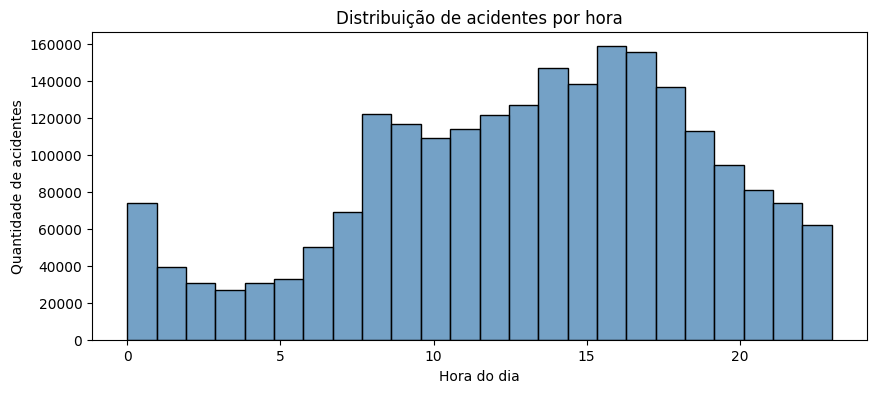

In [37]:
# ============================================= #
#  Análise: Distribuição de acidentes por hora  #
# ============================================= #

plt.figure(figsize=(10,4))
sns.histplot(collisions['hour'].dropna(), bins=24, kde=False, color='steelblue')
plt.title("Distribuição de acidentes por hora")
plt.xlabel("Hora do dia")
plt.ylabel("Quantidade de acidentes")
plt.show()


===== Distribuição do número de feridos =====
A maior parte dos acidentes não possui feridos, causando forte assimetria na distribuição.



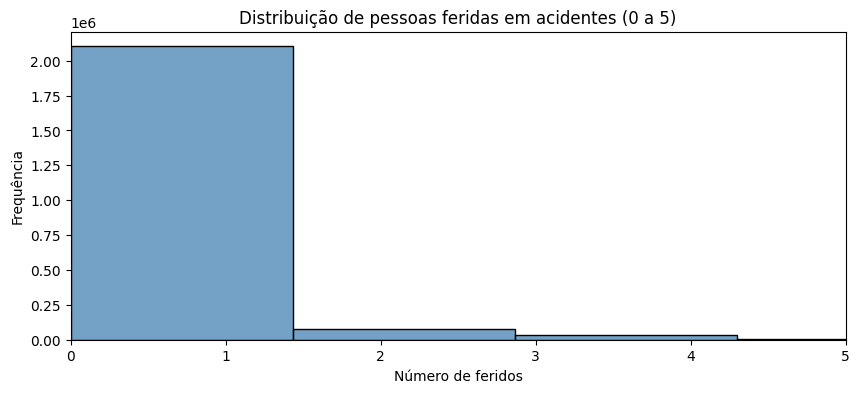

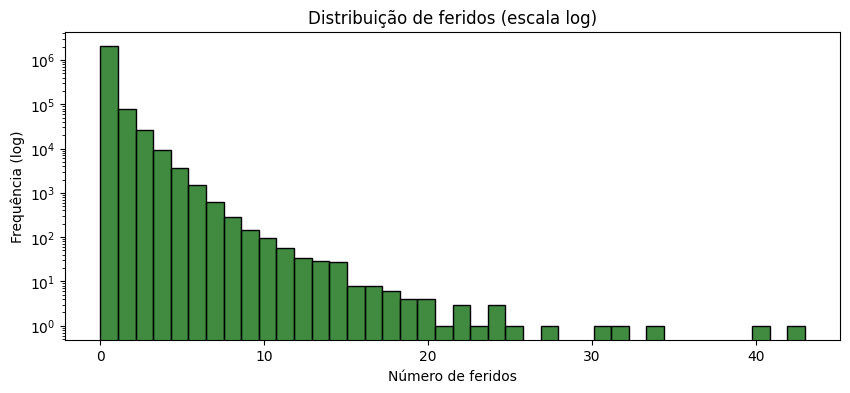

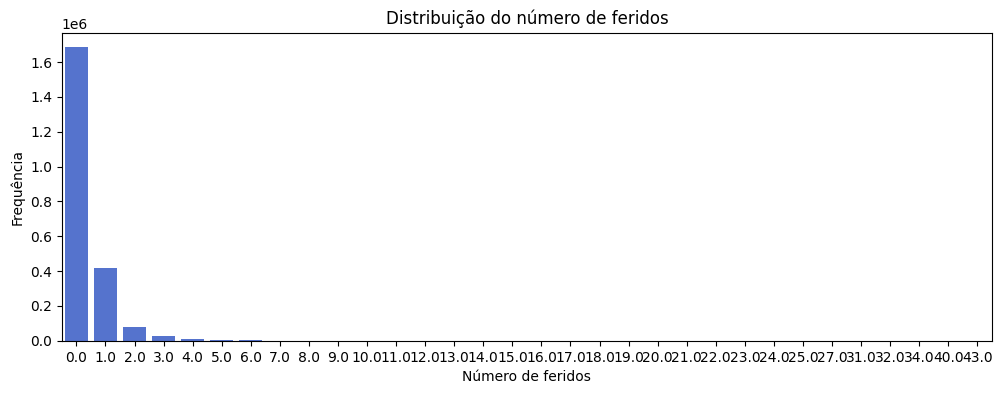

In [38]:
# ========================================================= #
#   Distribuição do número de feridos (versões melhoradas)  #
# ========================================================= #

print("===== Distribuição do número de feridos =====")
print("A maior parte dos acidentes não possui feridos, causando forte assimetria na distribuição.\n")

plt.figure(figsize=(10,4))
sns.histplot(collisions['number_of_persons_injured'], bins=30, color="steelblue")
plt.xlim(0, 5)
plt.title("Distribuição de pessoas feridas em acidentes (0 a 5)")
plt.xlabel("Número de feridos")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(10,4))
sns.histplot(collisions['number_of_persons_injured'], bins=40, color="darkgreen")
plt.yscale("log")
plt.title("Distribuição de feridos (escala log)")
plt.xlabel("Número de feridos")
plt.ylabel("Frequência (log)")
plt.show()

counts = collisions['number_of_persons_injured'].value_counts().sort_index()

plt.figure(figsize=(12,4))
sns.barplot(x=counts.index, y=counts.values, color="royalblue")
plt.title("Distribuição do número de feridos")
plt.xlabel("Número de feridos")
plt.ylabel("Frequência")
plt.show()



C:\Users\gubez\AppData\Local\Temp\ipykernel_14288\3438981789.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


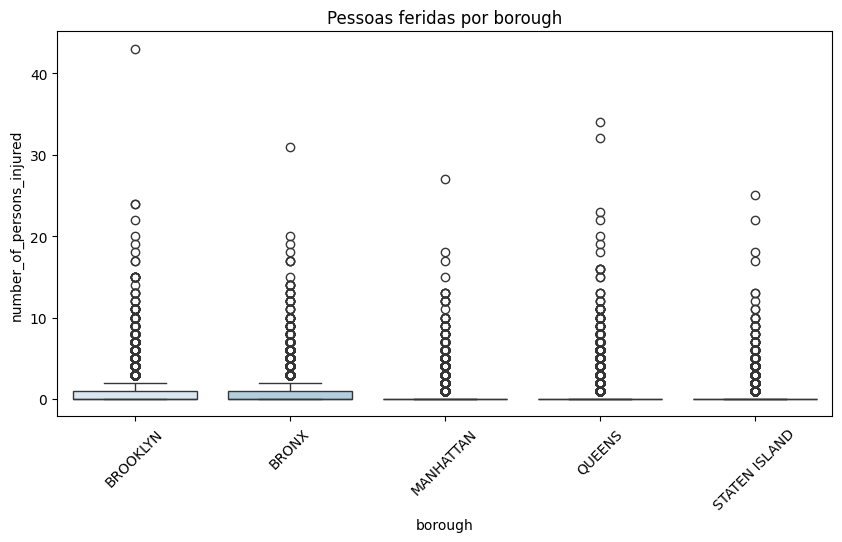

C:\Users\gubez\AppData\Local\Temp\ipykernel_14288\3438981789.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=collisions, x="borough", palette="Blues")


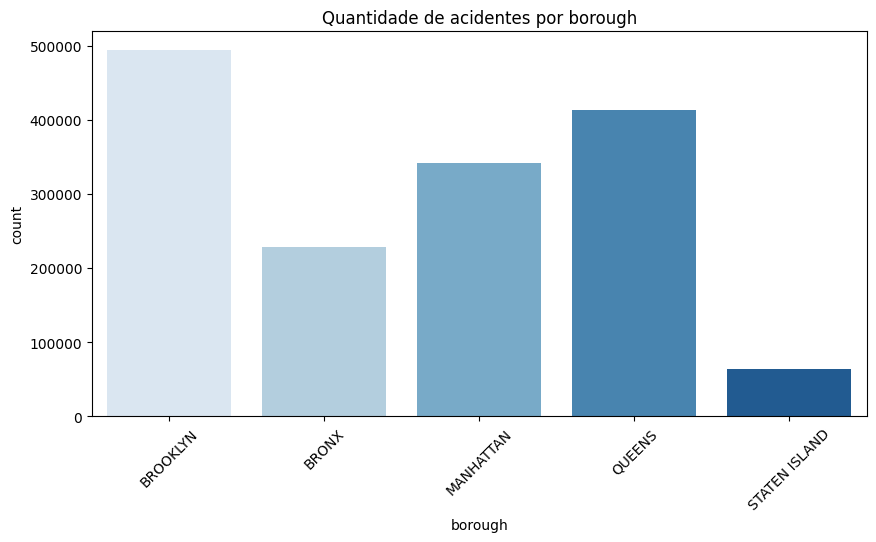

In [39]:
# ============================================= #
#    Boxplot: número de feridos por borough     #
# ============================================= #

plt.figure(figsize=(10,5))
sns.boxplot(
    data=collisions,
    x="borough",
    y="number_of_persons_injured",
    palette="Blues"
)
plt.title("Pessoas feridas por borough")
plt.xticks(rotation=45)
plt.show()

# ============================================= #
#      Contagem de acidentes por borough        #
# ============================================= #

plt.figure(figsize=(10,5))
sns.countplot(data=collisions, x="borough", palette="Blues")
plt.title("Quantidade de acidentes por borough")
plt.xticks(rotation=45)
plt.show()


In [40]:
# ======================================================= #
#   Probabilidade de ocorrência de feridos nos acidentes  #
# ======================================================= #

collisions["has_injuries"] = collisions["number_of_persons_injured"] > 0

p_injury = collisions["has_injuries"].mean()
print(f"Probabilidade de um acidente ter pessoas feridas: {p_injury:.2%}")

inj_by_borough = collisions.groupby("borough")["has_injuries"].mean()

print("\nProbabilidade de feridos por borough:")
display(inj_by_borough)


Probabilidade de um acidente ter pessoas feridas: 24.25%

Probabilidade de feridos por borough:


borough
BRONX            0.254422
BROOKLYN         0.263139
MANHATTAN        0.190901
QUEENS           0.239273
STATEN ISLAND    0.219930
Name: has_injuries, dtype: float64

In [41]:
ct = pd.crosstab(
    collisions['borough'],
    collisions['has_injuries']
)

chi2, p, dof, expected = chi2_contingency(ct)

print("===== TESTE QUI-QUADRADO =====")
print("p-value =", p)
print("Se p < 0.05, existe associação estatística entre borough e ocorrência de feridos.")
display(ct)


===== TESTE QUI-QUADRADO =====
p-value = 0.0
Se p < 0.05, existe associação estatística entre borough e ocorrência de feridos.


has_injuries,False,True
borough,,
BRONX,170249,58096
BROOKLYN,364207,130061
MANHATTAN,276461,65229
QUEENS,314346,98872
STATEN ISLAND,50366,14200


In [42]:
# ============================================= #
#        Odds e Odds Ratio por borough          #
# ============================================= #

p_inj = collisions['has_injuries'].mean()
p_noinj = 1 - p_inj

odds = p_inj / p_noinj
print(f"Odds geral de ter feridos: {odds:.3f}")

odds_borough = (inj_by_borough / (1 - inj_by_borough)).sort_values(ascending=False)

print("\nODDS por borough:")
display(odds_borough)


Odds geral de ter feridos: 0.320

ODDS por borough:


borough
BROOKLYN         0.357107
BRONX            0.341241
QUEENS           0.314532
STATEN ISLAND    0.281936
MANHATTAN        0.235943
Name: has_injuries, dtype: float64

## Passo 3: Probabilidade

===== DISTRIBUIÇÃO BINOMIAL - ACIDENTES COM FERIDOS =====
Total de acidentes: 2222829
Proporção de acidentes com feridos: 0.2425 (24.25%)

Distribuição Binomial - Probabilidade de X acidentes com feridos em 10 acidentes:
P(X = 0) = 0.0622
P(X = 1) = 0.1991
P(X = 2) = 0.2869
P(X = 3) = 0.2449
P(X = 4) = 0.1372
P(X = 5) = 0.0527
P(X = 6) = 0.0141
P(X = 7) = 0.0026
P(X = 8) = 0.0003
P(X = 9) = 0.0000
P(X = 10) = 0.0000

Probabilidade de pelo menos 3 acidentes com feridos em 10: 0.4519


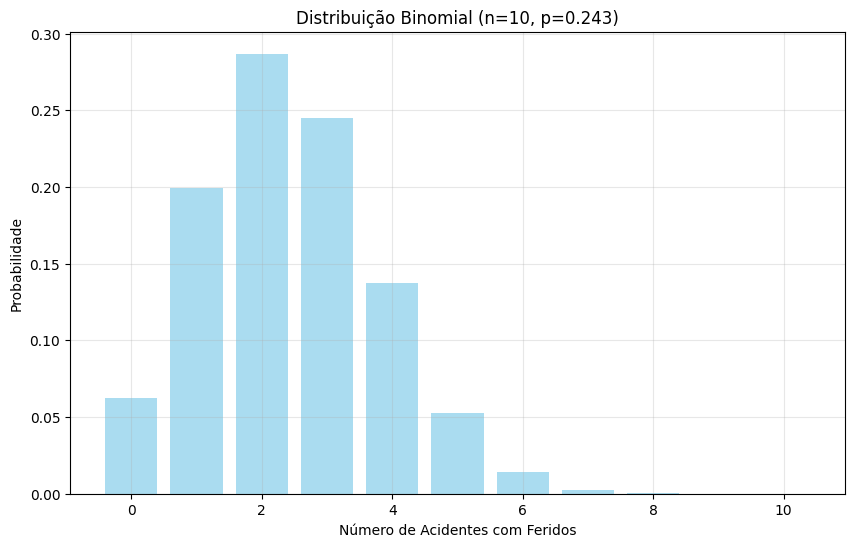

In [43]:
# ======================================= #
#          Distribuição Binomial          #
# ======================================= #

print("===== DISTRIBUIÇÃO BINOMIAL - ACIDENTES COM FERIDOS =====")

# Probabilidade de um acidente ter pelo menos 1 ferido
n_accidents = len(collisions)
accidents_with_injuries = collisions['number_of_persons_injured'] > 0
p_injury = accidents_with_injuries.mean()

print(f"Total de acidentes: {n_accidents}")
print(f"Proporção de acidentes com feridos: {p_injury:.4f} ({p_injury*100:.2f}%)")

# Parâmetros da binomial
n = 10  # número de acidentes
p = p_injury  # probabilidade de sucesso (acidente com ferido)

print(f"\nDistribuição Binomial - Probabilidade de X acidentes com feridos em {n} acidentes:")
for k in range(n + 1):
    prob = binom.pmf(k, n, p)
    print(f"P(X = {k}) = {prob:.4f}")

# Probabilidade de pelo menos 3 acidentes com feridos em 10
prob_at_least_3 = 1 - binom.cdf(2, n, p)
print(f"\nProbabilidade de pelo menos 3 acidentes com feridos em {n}: {prob_at_least_3:.4f}")

# Gráfico da distribuição binomial
plt.figure(figsize=(10, 6))
x = np.arange(0, n + 1)
y = binom.pmf(x, n, p)

plt.bar(x, y, color='skyblue', alpha=0.7)
plt.xlabel('Número de Acidentes com Feridos')
plt.ylabel('Probabilidade')
plt.title(f'Distribuição Binomial (n={n}, p={p:.3f})')
plt.grid(True, alpha=0.3)
plt.show()

===== DISTRIBUIÇÃO DE POISSON - ACIDENTES POR HORA =====
Taxa média de acidentes por hora (λ): 92617.88

Distribuição de Poisson - Probabilidade de X acidentes em uma hora:
P(X = 0) = 0.0000
P(X = 1) = 0.0000
P(X = 2) = 0.0000
P(X = 3) = 0.0000
P(X = 4) = 0.0000
P(X = 5) = 0.0000
P(X = 6) = 0.0000
P(X = 7) = 0.0000
P(X = 8) = 0.0000
P(X = 9) = 0.0000
P(X = 10) = 0.0000

Probabilidade de mais de 15 acidentes em uma hora: 1.0000


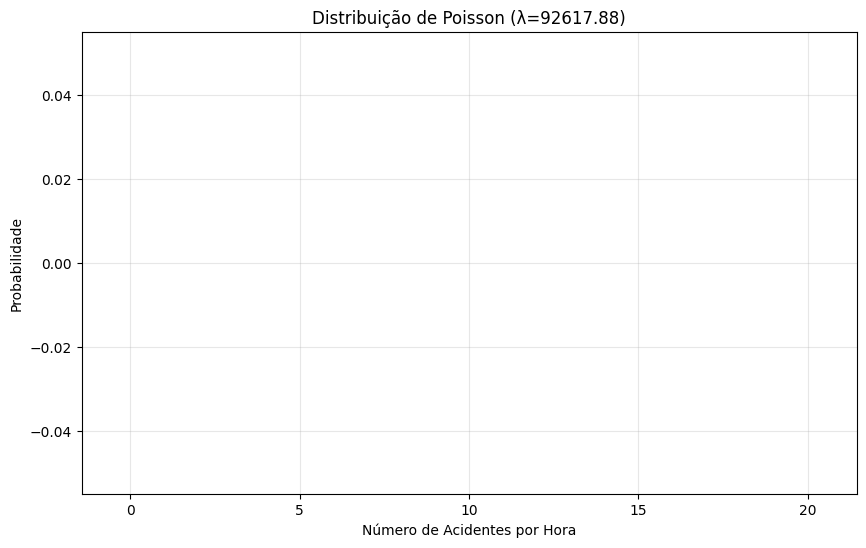

In [44]:
# ======================================= #
#        Distribuição de Poisson          #
# ======================================= #

print("===== DISTRIBUIÇÃO DE POISSON - ACIDENTES POR HORA =====")

# Calcular taxa média de acidentes por hora
hourly_accidents = collisions['hour'].value_counts().sort_index()
lambda_poisson = hourly_accidents.mean()

print(f"Taxa média de acidentes por hora (λ): {lambda_poisson:.2f}")

print(f"\nDistribuição de Poisson - Probabilidade de X acidentes em uma hora:")
for k in range(0, 11):  # de 0 a 10 acidentes
    prob = poisson.pmf(k, lambda_poisson)
    print(f"P(X = {k}) = {prob:.4f}")

# Probabilidade de mais de 15 acidentes em uma hora
prob_more_than_15 = 1 - poisson.cdf(15, lambda_poisson)
print(f"\nProbabilidade de mais de 15 acidentes em uma hora: {prob_more_than_15:.4f}")

# Gráfico da distribuição de Poisson
plt.figure(figsize=(10, 6))
x = np.arange(0, 21)  # de 0 a 20 acidentes
y = poisson.pmf(x, lambda_poisson)

plt.bar(x, y, color='lightcoral', alpha=0.7)
plt.xlabel('Número de Acidentes por Hora')
plt.ylabel('Probabilidade')
plt.title(f'Distribuição de Poisson (λ={lambda_poisson:.2f})')
plt.grid(True, alpha=0.3)
plt.show()

===== DISTRIBUIÇÃO NORMAL - NÚMERO DE FERIDOS =====
Média de feridos por acidente: 0.3285
Desvio padrão: 0.7151

Teste de Shapiro-Wilk para normalidade:
Estatística: 0.5041, p-value: 0.0000
Os dados NÃO seguem distribuição normal

Probabilidades usando distribuição normal:
P(0 feridos) ≈ 0.4715
P(1 ferido) ≈ 0.3545
P(2+ feridos) ≈ 0.0507


c:\Users\gubez\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 2222829.
  res = hypotest_fun_out(*samples, **kwds)


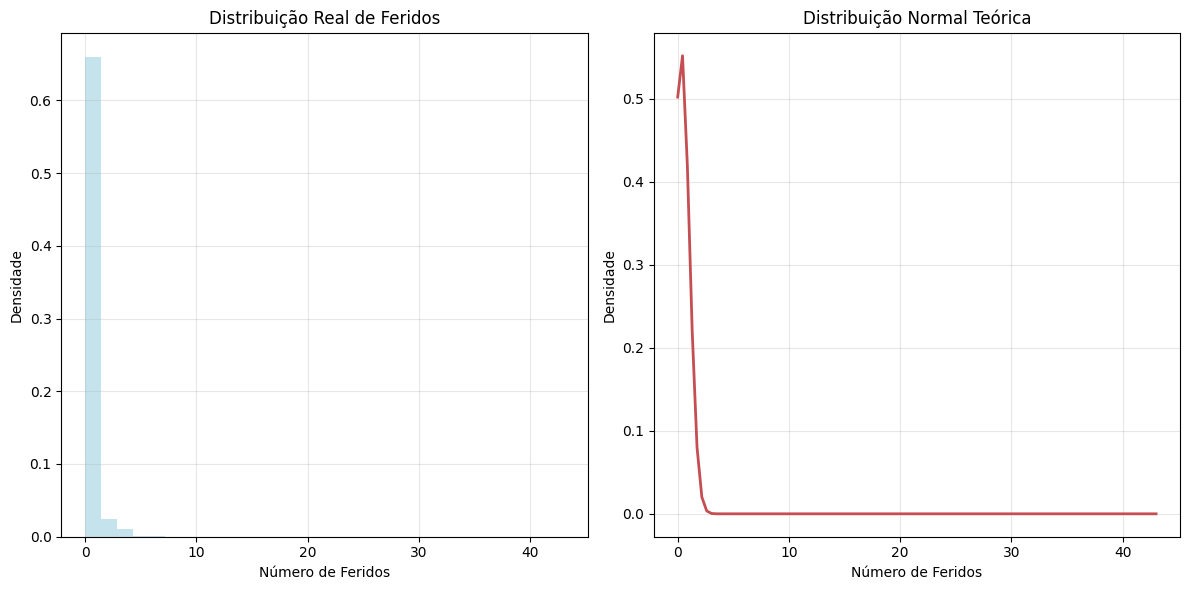

In [45]:
# ======================================= #
#           Distribuição Normal           #
# ======================================= #

print("===== DISTRIBUIÇÃO NORMAL - NÚMERO DE FERIDOS =====")

# Analisar a distribuição do número de feridos
injuries_data = collisions['number_of_persons_injured'].dropna()
mean_injuries = injuries_data.mean()
std_injuries = injuries_data.std()

print(f"Média de feridos por acidente: {mean_injuries:.4f}")
print(f"Desvio padrão: {std_injuries:.4f}")

# Testar se segue distribuição normal
stat, p_value = shapiro(injuries_data)
print(f"\nTeste de Shapiro-Wilk para normalidade:")
print(f"Estatística: {stat:.4f}, p-value: {p_value:.4f}")

if p_value > 0.05:
    print("Os dados seguem distribuição normal")
else:
    print("Os dados NÃO seguem distribuição normal")

# Calcular probabilidades usando distribuição normal
print(f"\nProbabilidades usando distribuição normal:")
prob_0_injuries = norm.cdf(0.5, mean_injuries, std_injuries) - norm.cdf(-0.5, mean_injuries, std_injuries)
prob_1_injury = norm.cdf(1.5, mean_injuries, std_injuries) - norm.cdf(0.5, mean_injuries, std_injuries)
prob_2_plus_injuries = 1 - norm.cdf(1.5, mean_injuries, std_injuries)

print(f"P(0 feridos) ≈ {prob_0_injuries:.4f}")
print(f"P(1 ferido) ≈ {prob_1_injury:.4f}")
print(f"P(2+ feridos) ≈ {prob_2_plus_injuries:.4f}")

# Gráfico comparativo: dados reais vs normal
plt.figure(figsize=(12, 6))

# Histograma dos dados reais
plt.subplot(1, 2, 1)
plt.hist(injuries_data, bins=30, density=True, alpha=0.7, color='lightblue', label='Dados Reais')
plt.xlabel('Número de Feridos')
plt.ylabel('Densidade')
plt.title('Distribuição Real de Feridos')
plt.grid(True, alpha=0.3)

# Distribuição normal teórica
plt.subplot(1, 2, 2)
x = np.linspace(injuries_data.min(), injuries_data.max(), 100)
y = norm.pdf(x, mean_injuries, std_injuries)
plt.plot(x, y, 'r-', linewidth=2, label='Distribuição Normal')
plt.xlabel('Número de Feridos')
plt.ylabel('Densidade')
plt.title('Distribuição Normal Teórica')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
# ======================================= #
#            Teorema de Bayes             #
# ======================================= #

print("===== TEOREMA DE BAYES - PROBABILIDADES CONDICIONAIS =====")

# Exemplo: Probabilidade de acidente grave dado que ocorreu em Manhattan
collisions['severe_accident'] = collisions['number_of_persons_injured'] >= 2

# Probabilidades a priori
p_manhattan = (collisions['borough'] == 'MANHATTAN').mean()
p_severe = collisions['severe_accident'].mean()

print(f"Probabilidade a priori de acidente em Manhattan: {p_manhattan:.4f}")
print(f"Probabilidade a priori de acidente grave: {p_severe:.4f}")

# Probabilidade condicional
manhattan_accidents = collisions[collisions['borough'] == 'MANHATTAN']
p_severe_given_manhattan = manhattan_accidents['severe_accident'].mean()

print(f"Probabilidade de acidente grave dado Manhattan: {p_severe_given_manhattan:.4f}")

# Aplicar Teorema de Bayes
# P(Manhattan | Severe) = P(Severe | Manhattan) * P(Manhattan) / P(Severe)
p_manhattan_given_severe = (p_severe_given_manhattan * p_manhattan) / p_severe

print(f"\nAplicando Teorema de Bayes:")
print(f"P(Manhattan | Grave) = P(Grave | Manhattan) × P(Manhattan) / P(Grave)")
print(f"P(Manhattan | Grave) = {p_severe_given_manhattan:.4f} × {p_manhattan:.4f} / {p_severe:.4f}")
print(f"P(Manhattan | Grave) = {p_manhattan_given_severe:.4f}")

# Comparar com probabilidade empírica
severe_accidents = collisions[collisions['severe_accident'] == True]
p_manhattan_given_severe_empirical = (severe_accidents['borough'] == 'MANHATTAN').mean()

print(f"\nVerificação empírica:")
print(f"Proporção de Manhattan entre acidentes graves: {p_manhattan_given_severe_empirical:.4f}")

# Matriz de probabilidades condicionais por borough
print(f"\nProbabilidades Condicionais por Borough:")
boroughs_to_check = ['MANHATTAN', 'BROOKLYN', 'QUEENS'][:3]  # Primeiros 3

for borough in boroughs_to_check:
    borough_data = collisions[collisions['borough'] == borough]
    p_severe_given_borough = borough_data['severe_accident'].mean()
    p_fatal_given_borough = (borough_data['number_of_persons_killed'] > 0).mean()

    print(f"\n{borough}:")
    print(f"  P(Grave | {borough}) = {p_severe_given_borough:.4f}")
    print(f"  P(Fatal | {borough}) = {p_fatal_given_borough:.4f}")

===== TEOREMA DE BAYES - PROBABILIDADES CONDICIONAIS =====
Probabilidade a priori de acidente em Manhattan: 0.1537
Probabilidade a priori de acidente grave: 0.0542
Probabilidade de acidente grave dado Manhattan: 0.0245

Aplicando Teorema de Bayes:
P(Manhattan | Grave) = P(Grave | Manhattan) × P(Manhattan) / P(Grave)
P(Manhattan | Grave) = 0.0245 × 0.1537 / 0.0542
P(Manhattan | Grave) = 0.0697

Verificação empírica:
Proporção de Manhattan entre acidentes graves: 0.0697

Probabilidades Condicionais por Borough:

MANHATTAN:
  P(Grave | MANHATTAN) = 0.0245
  P(Fatal | MANHATTAN) = 0.0011

BROOKLYN:
  P(Grave | BROOKLYN) = 0.0556
  P(Fatal | BROOKLYN) = 0.0014

QUEENS:
  P(Grave | QUEENS) = 0.0517
  P(Fatal | QUEENS) = 0.0014


## Passo 4: Inferência

===== ESTIMADORES PONTUAIS =====


C:\Users\gubez\AppData\Local\Temp\ipykernel_14288\1908622530.py:14: DeprecationWarning: Please import `trim_mean` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  'Média Aparada (10%)': stats.trim_mean(injuries_clean, 0.1),


Estimadores para o número de feridos por acidente:
Média: 0.3285
Mediana: 0.0000
Moda: 0.0000
Média Aparada (10%): 0.1782
Desvio Padrão: 0.7151
Erro Padrão: 0.0005

Análise de Viés:
Diferença Média-Mediana: 0.3285
Coeficiente de Variação: 2.1768


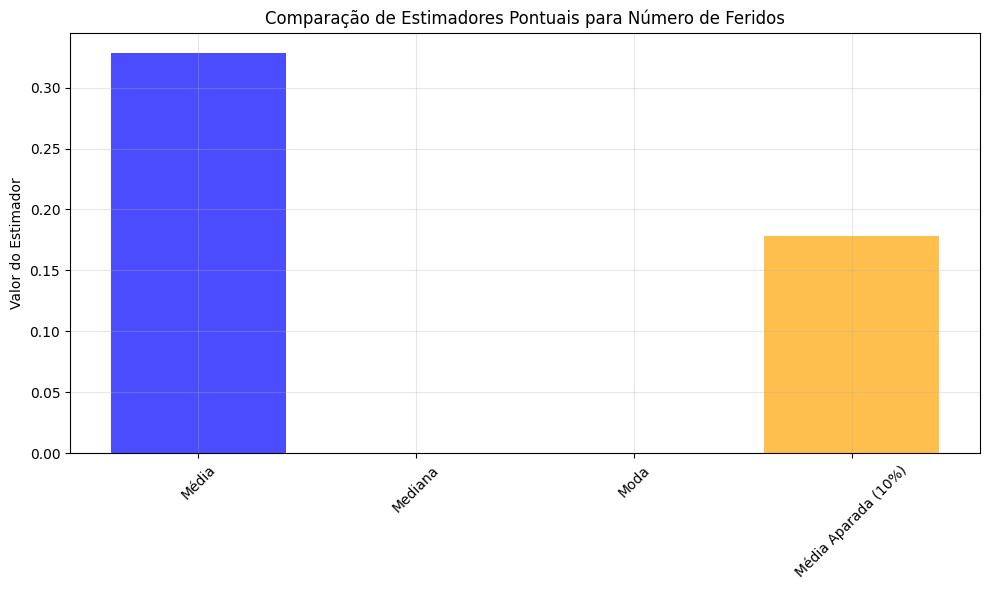

In [47]:
# ======================================= #
#          Estimadores Pontuais           #
# ======================================= #

print("===== ESTIMADORES PONTUAIS =====")

# Calcular vários estimadores para o número de feridos
injuries_clean = collisions['number_of_persons_injured'].dropna()

estimators = {
    'Média': injuries_clean.mean(),
    'Mediana': injuries_clean.median(),
    'Moda': injuries_clean.mode()[0] if not injuries_clean.mode().empty else 0,
    'Média Aparada (10%)': stats.trim_mean(injuries_clean, 0.1),
    'Desvio Padrão': injuries_clean.std(),
    'Erro Padrão': injuries_clean.std() / np.sqrt(len(injuries_clean))
}

print("Estimadores para o número de feridos por acidente:")
for name, value in estimators.items():
    print(f"{name}: {value:.4f}")

# Viés dos estimadores
print(f"\nAnálise de Viés:")
print(f"Diferença Média-Mediana: {estimators['Média'] - estimators['Mediana']:.4f}")
print(f"Coeficiente de Variação: {(estimators['Desvio Padrão'] / estimators['Média']):.4f}")

# Gráfico comparativo dos estimadores
plt.figure(figsize=(10, 6))
names = list(estimators.keys())[:4]  # Primeiros 4 estimadores
values = list(estimators.values())[:4]

plt.bar(names, values, color=['blue', 'green', 'red', 'orange'], alpha=0.7)
plt.ylabel('Valor do Estimador')
plt.title('Comparação de Estimadores Pontuais para Número de Feridos')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
# ======================================= #
#        Intervalos de Confiança          #
# ======================================= #

print("===== INTERVALOS DE CONFIANÇA =====")

# IC para média de feridos
n = len(injuries_clean)
mean_injuries = injuries_clean.mean()
std_injuries = injuries_clean.std()

# IC 95% usando distribuição t
confidence_level = 0.95
t_critical = stats.t.ppf((1 + confidence_level) / 2, n - 1)
margin_error = t_critical * (std_injuries / np.sqrt(n))

ci_lower = mean_injuries - margin_error
ci_upper = mean_injuries + margin_error

print(f"Intervalo de Confiança 95% para média de feridos:")
print(f"Amostra: n = {n}, Média = {mean_injuries:.4f}, DP = {std_injuries:.4f}")
print(f"IC 95%: ({ci_lower:.4f}, {ci_upper:.4f})")
print(f"Margem de erro: ±{margin_error:.4f}")

# IC para diferentes níveis de confiança
print(f"\nIntervalos para diferentes níveis de confiança:")
conf_levels = [0.90, 0.95, 0.99]

for cl in conf_levels:
    t_crit = stats.t.ppf((1 + cl) / 2, n - 1)
    me = t_crit * (std_injuries / np.sqrt(n))
    lower = mean_injuries - me
    upper = mean_injuries + me
    print(f"IC {int(cl*100)}%: ({lower:.4f}, {upper:.4f}) - Margem: ±{me:.4f}")

# IC para proporção de acidentes com feridos
p_hat = (collisions['number_of_persons_injured'] > 0).mean()
n_total = len(collisions)

z_critical = stats.norm.ppf((1 + confidence_level) / 2)
me_prop = z_critical * np.sqrt((p_hat * (1 - p_hat)) / n_total)

ci_lower_prop = p_hat - me_prop
ci_upper_prop = p_hat + me_prop

print(f"\nIntervalo de Confiança 95% para proporção de acidentes com feridos:")
print(f"Proporção amostral: {p_hat:.4f} ({p_hat*100:.2f}%)")
print(f"IC 95%: ({ci_lower_prop:.4f}, {ci_upper_prop:.4f})")
print(f"Interpretação: Entre {ci_lower_prop*100:.1f}% e {ci_upper_prop*100:.1f}% dos acidentes têm feridos")

===== INTERVALOS DE CONFIANÇA =====
Intervalo de Confiança 95% para média de feridos:
Amostra: n = 2222829, Média = 0.3285, DP = 0.7151
IC 95%: (0.3276, 0.3294)
Margem de erro: ±0.0009

Intervalos para diferentes níveis de confiança:
IC 90%: (0.3277, 0.3293) - Margem: ±0.0008
IC 95%: (0.3276, 0.3294) - Margem: ±0.0009
IC 99%: (0.3273, 0.3297) - Margem: ±0.0012

Intervalo de Confiança 95% para proporção de acidentes com feridos:
Proporção amostral: 0.2425 (24.25%)
IC 95%: (0.2420, 0.2431)
Interpretação: Entre 24.2% e 24.3% dos acidentes têm feridos


In [ ]:
# ======================================= #
#        Distribuição t e Normal          #
# ======================================= #

print("===== COMPARAÇÃO: DISTRIBUIÇÃO t vs NORMAL =====")

# Comparar distribuição t com normal para diferentes tamanhos amostrais
sample_sizes = [10, 30, 100, len(injuries_clean)]
x = np.linspace(-3, 3, 100)

plt.figure(figsize=(12, 8))

for i, size in enumerate(sample_sizes, 1):
    plt.subplot(2, 2, i)

    # Distribuição normal padrão
    y_normal = norm.pdf(x)
    plt.plot(x, y_normal, 'b-', linewidth=2, label='Normal(0,1)')

    # Distribuição t com n-1 graus de liberdade
    if size > 1:
        y_t = stats.t.pdf(x, size - 1)
        plt.plot(x, y_t, 'r--', linewidth=2, label=f't({size-1} gl)')

    plt.title(f'n = {size}')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.show()

# Valores críticos comparativos
print("Valores críticos para α = 0.05 (bilateral):")
for size in [10, 30, 100, len(injuries_clean)]:
    if size > 1:
        t_crit = stats.t.ppf(0.975, size - 1)
        z_crit = norm.ppf(0.975)
        diff = t_crit - z_crit
        print(f"n={size}: t={t_crit:.4f}, z={z_crit:.4f}, diferença={diff:.4f}")

===== INTERVALOS DE CONFIANÇA POR BOROUGH =====

Intervalos de Confiança 95% por Borough:
BROOKLYN        Média: 0.351 IC: (0.349, 0.353) n: 494268
BRONX           Média: 0.348 IC: (0.345, 0.351) n: 228345
QUEENS          Média: 0.319 IC: (0.317, 0.321) n: 413218
STATEN ISLAND   Média: 0.301 IC: (0.296, 0.307) n: 64566
MANHATTAN       Média: 0.228 IC: (0.226, 0.230) n: 341690


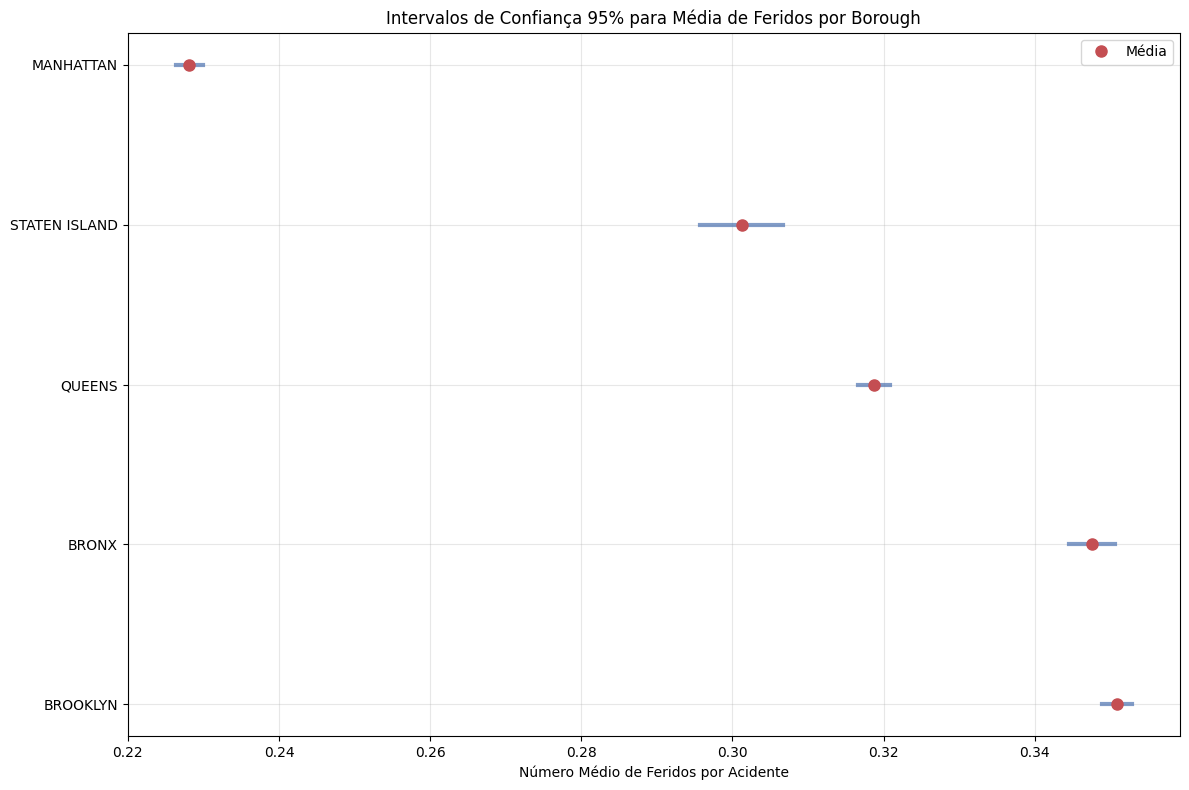

In [51]:
# ======================================= #
#    Aplicação Prática - IC por Grupo     #
# ======================================= #

print("===== INTERVALOS DE CONFIANÇA POR BOROUGH =====")

# Calcular IC 95% para média de feridos por borough
borough_ci_data = []

for borough in collisions['borough'].value_counts().index[:5]:  # Top 5 boroughs
    borough_data = collisions[collisions['borough'] == borough]['number_of_persons_injured'].dropna()

    if len(borough_data) > 1:
        n_borough = len(borough_data)
        mean_borough = borough_data.mean()
        std_borough = borough_data.std()

        t_critical_borough = stats.t.ppf(0.975, n_borough - 1)
        me_borough = t_critical_borough * (std_borough / np.sqrt(n_borough))

        borough_ci_data.append({
            'borough': borough,
            'n': n_borough,
            'mean': mean_borough,
            'std': std_borough,
            'ci_lower': mean_borough - me_borough,
            'ci_upper': mean_borough + me_borough,
            'me': me_borough
        })

# Criar DataFrame e ordenar por média
ci_df = pd.DataFrame(borough_ci_data).sort_values('mean', ascending=False)

print("\nIntervalos de Confiança 95% por Borough:")
for _, row in ci_df.iterrows():
    print(f"{row['borough']:15} Média: {row['mean']:.3f} IC: ({row['ci_lower']:.3f}, {row['ci_upper']:.3f}) n: {row['n']}")

# Visualização gráfica
plt.figure(figsize=(12, 8))

# Plotar ICs
for i, (_, row) in enumerate(ci_df.iterrows()):
    plt.plot([row['ci_lower'], row['ci_upper']], [i, i], 'b-', linewidth=3, alpha=0.7)
    plt.plot(row['mean'], i, 'ro', markersize=8, label='Média' if i == 0 else "")

plt.yticks(range(len(ci_df)), ci_df['borough'])
plt.xlabel('Número Médio de Feridos por Acidente')
plt.title('Intervalos de Confiança 95% para Média de Feridos por Borough')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 5. Teste de hipóteses

In [52]:
# ======================================= #
#   Teste de Normalidade (Shapiro-Wilk)   #
# ======================================= #

print("===== TESTE DE NORMALIDADE - SHAPIRO-WILK =====")

from scipy.stats import shapiro

variables_to_test = ['number_of_persons_injured', 'number_of_persons_killed', 'hour']

print("Resultados do Teste de Shapiro-Wilk:")
print("H₀: Os dados seguem distribuição normal")
print("H₁: Os dados NÃO seguem distribuição normal")
print("α = 0.05\n")

for var in variables_to_test:
    if var in collisions.columns:
        data = collisions[var].dropna()
        if len(data) > 3:
            stat, p_value = shapiro(data)
            print(f"\n{var}:")
            print(f"  Estatística W = {stat:.4f}, p-value = {p_value:.4f}")
            if p_value > 0.05:
                print(f"  → Não rejeita H₀: Distribuição normal")
            else:
                print(f"  → Rejeita H₀: Distribuição NÃO normal")

===== TESTE DE NORMALIDADE - SHAPIRO-WILK =====
Resultados do Teste de Shapiro-Wilk:
H₀: Os dados seguem distribuição normal
H₁: Os dados NÃO seguem distribuição normal
α = 0.05


number_of_persons_injured:
  Estatística W = 0.5041, p-value = 0.0000
  → Rejeita H₀: Distribuição NÃO normal

number_of_persons_killed:
  Estatística W = 0.0154, p-value = 0.0000
  → Rejeita H₀: Distribuição NÃO normal

hour:
  Estatística W = 0.9680, p-value = 0.0000
  → Rejeita H₀: Distribuição NÃO normal


c:\Users\gubez\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 2222829.
  res = hypotest_fun_out(*samples, **kwds)


In [53]:
# ======================================= #
#    Teste t para Comparação de Médias    #
# ======================================= #

print("===== TESTE t - COMPARAÇÃO DE MÉDIAS ENTRE BOROUGHS =====")

from scipy.stats import ttest_ind, levene

manhattan_injuries = collisions[collisions['borough'] == 'MANHATTAN']['number_of_persons_injured'].dropna()
brooklyn_injuries = collisions[collisions['borough'] == 'BROOKLYN']['number_of_persons_injured'].dropna()

print("Teste t: Manhattan vs Brooklyn (número de feridos)")
print("H₀: μ_manhattan = μ_brooklyn")
print("H₁: μ_manhattan ≠ μ_brooklyn")
print("α = 0.05\n")

# Verificar variâncias
levene_stat, levene_p = levene(manhattan_injuries, brooklyn_injuries)
print(f"Teste de Levene: p-value = {levene_p:.4f}")

equal_var = True if levene_p > 0.05 else False

# Teste t
t_stat, p_value = ttest_ind(manhattan_injuries, brooklyn_injuries, equal_var=equal_var)

print(f"\nResultado do Teste t:")
print(f"Estatística t = {t_stat:.4f}")
print(f"p-value = {p_value:.4f}")

if p_value <= 0.05:
    print("→ REJEITA H₀: Há diferença significativa entre as médias")
else:
    print("→ NÃO REJEITA H₀: Não há diferença significativa entre as médias")

===== TESTE t - COMPARAÇÃO DE MÉDIAS ENTRE BOROUGHS =====
Teste t: Manhattan vs Brooklyn (número de feridos)
H₀: μ_manhattan = μ_brooklyn
H₁: μ_manhattan ≠ μ_brooklyn
α = 0.05

Teste de Levene: p-value = 0.0000

Resultado do Teste t:
Estatística t = -88.2933
p-value = 0.0000
→ REJEITA H₀: Há diferença significativa entre as médias


In [54]:
# ======================================= #
#   Teste Não Paramétrico (Mann-Whitney)  #
# ======================================= #

print("===== TESTE DE MANN-WHITNEY - COMPARAÇÃO NÃO PARAMÉTRICA =====")

from scipy.stats import mannwhitneyu

print("Teste de Mann-Whitney: Manhattan vs Brooklyn")
print("H₀: As distribuições são iguais")
print("H₁: As distribuições são diferentes")
print("α = 0.05\n")

stat, p_value = mannwhitneyu(manhattan_injuries, brooklyn_injuries, alternative='two-sided')

print(f"Resultado do Teste de Mann-Whitney:")
print(f"Estatística U = {stat:.4f}")
print(f"p-value = {p_value:.4f}")

if p_value <= 0.05:
    print("→ REJEITA H₀: As distribuições são significativamente diferentes")
else:
    print("→ NÃO REJEITA H₀: Não há diferença significativa entre as distribuições")

===== TESTE DE MANN-WHITNEY - COMPARAÇÃO NÃO PARAMÉTRICA =====
Teste de Mann-Whitney: Manhattan vs Brooklyn
H₀: As distribuições são iguais
H₁: As distribuições são diferentes
α = 0.05

Resultado do Teste de Mann-Whitney:
Estatística U = 77988428255.5000
p-value = 0.0000
→ REJEITA H₀: As distribuições são significativamente diferentes


In [55]:
# ======================================= #
#    Teste Qui-Quadrado para Proporções   #
# ======================================= #

print("===== TESTE QUI-QUADRADO - PROPORÇÃO DE ACIDENTES GRAVES =====")

from scipy.stats import chi2_contingency

collisions['severe_accident'] = collisions['number_of_persons_injured'] >= 2
contingency_data = collisions[collisions['borough'].isin(['MANHATTAN', 'BROOKLYN', 'QUEENS'])]
contingency_table = pd.crosstab(contingency_data['borough'], contingency_data['severe_accident'])

print("Tabela de Contingência:")
print(contingency_table)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"\nTeste Qui-quadrado de Independência:")
print(f"H₀: Não há associação entre borough e severidade do acidente")
print(f"H₁: Há associação entre borough e severidade do acidente")
print(f"α = 0.05\n")

print(f"Estatística Qui-quadrado = {chi2:.4f}")
print(f"p-value = {p_value:.4f}")

if p_value <= 0.05:
    print("→ REJEITA H₀: Há associação significativa entre borough e severidade")
else:
    print("→ NÃO REJEITA H₀: Não há associação significativa")

===== TESTE QUI-QUADRADO - PROPORÇÃO DE ACIDENTES GRAVES =====
Tabela de Contingência:
severe_accident   False  True 
borough                       
BROOKLYN         466781  27487
MANHATTAN        333304   8386
QUEENS           391860  21358

Teste Qui-quadrado de Independência:
H₀: Não há associação entre borough e severidade do acidente
H₁: Há associação entre borough e severidade do acidente
α = 0.05

Estatística Qui-quadrado = 4947.8928
p-value = 0.0000
→ REJEITA H₀: Há associação significativa entre borough e severidade


In [56]:
# ======================================= #
#      ANOVA para Múltiplos Grupos        #
# ======================================= #

print("===== ANOVA - COMPARAÇÃO DE MÉDIAS ENTRE MÚLTIPLOS BOROUGHS =====")

from scipy.stats import f_oneway

groups = []
borough_names = []

for borough in ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX']:
    borough_data = collisions[collisions['borough'] == borough]['number_of_persons_injured'].dropna()
    if len(borough_data) > 0:
        groups.append(borough_data)
        borough_names.append(borough)

print("ANOVA: Comparação de médias entre múltiplos boroughs")
print("H₀: μ_manhattan = μ_brooklyn = μ_queens = μ_bronx")
print("H₁: Pelo menos uma média é diferente")
print("α = 0.05\n")

f_stat, p_value = f_oneway(*groups)

print(f"Resultado da ANOVA:")
print(f"Estatística F = {f_stat:.4f}")
print(f"p-value = {p_value:.4f}")

if p_value <= 0.05:
    print("→ REJEITA H₀: Há diferenças significativas entre pelo menos um par de boroughs")
else:
    print("→ NÃO REJEITA H₀: Não há diferenças significativas entre os boroughs")

===== ANOVA - COMPARAÇÃO DE MÉDIAS ENTRE MÚLTIPLOS BOROUGHS =====
ANOVA: Comparação de médias entre múltiplos boroughs
H₀: μ_manhattan = μ_brooklyn = μ_queens = μ_bronx
H₁: Pelo menos uma média é diferente
α = 0.05

Resultado da ANOVA:
Estatística F = 2485.0665
p-value = 0.0000
→ REJEITA H₀: Há diferenças significativas entre pelo menos um par de boroughs
